In [1]:
import json
import pandas as pd
import numpy as np
from noggin import create_plot
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
file_path1 = r"Sarcasm_Headlines_Dataset.json"
df = pd.read_json(file_path1,lines=True)
df = df[['headline','is_sarcastic']]
#print(df[:50])

In [6]:
df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


In [7]:
x = np.asarray(df)

In [8]:
x.shape

(26709, 2)

In [9]:
x[:,1]

array([0, 0, 1, ..., 0, 0, 0], dtype=object)

In [10]:
import random
import numpy as np

def train_split(data, validation=0.2):
    N = len(data)
    print(N)
    breakpoint = int(validation*N)
    
    data_idxs = list(np.arange(N))
    
    random.shuffle(data_idxs)
    #print(data_idxs)
    
    return data[data_idxs[:breakpoint], :], data[data_idxs[breakpoint:], :]

In [11]:
testing_data, training_data = train_split(x)

26709


In [12]:
testing_data.shape
testing_data

array([['second life makes dream of owning fictitious coffee shop come true',
        1],
       ['trump refugee order dashes hopes of iraqis who helped the u.s.',
        0],
       ['walton foundation pledges $1 billion for charter schools', 0],
       ...,
       ['judge dismisses domestic violence charges against ray rice; now what?',
        0],
       ['chita rivera to young performers: learn how to sing and dance',
        0],
       ['vr pioneer chris milk: virtual reality will mirror life like nothing else before',
        0]], dtype=object)

In [13]:
training_data

array([['grown man who owns bane action figure has love to give', 1],
       ['dolphin spends amazing vacation swimming with stockbroker', 1],
       ['finding comfort in numbers', 0],
       ...,
       ["arianna huffington urges gop voters to 'trexit' and dump trump",
        0],
       ["don't expect to see kim kardashian give birth on tv again", 0],
       ["'troubled' republicans have no plans to do anything about james comey's firing",
        0]], dtype=object)

In [14]:
training_data.shape

(21368, 2)

In [15]:
#tokenizer stuff
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

def tokenize(data):
    tokens = [tokenizer(headline) for headline in data[:, 0]]
    return tokens

In [16]:
tokenizedTrainingData = tokenize(training_data)
tokenizedTestingData = tokenize(testing_data)

In [17]:
tokenizedTrainingData

[['grown',
  'man',
  'who',
  'owns',
  'bane',
  'action',
  'figure',
  'has',
  'love',
  'to',
  'give'],
 ['dolphin',
  'spends',
  'amazing',
  'vacation',
  'swimming',
  'with',
  'stockbroker'],
 ['finding', 'comfort', 'in', 'numbers'],
 ['ex-wife',
  'of',
  'former',
  'cowboys',
  'player',
  'claims',
  'team',
  'knew',
  'of',
  'domestic',
  'abuse'],
 ['bathroom', 'smells', 'like', 'shit'],
 ['christian', 'resistance', 'to', 'trump', 'is', 'growing'],
 ['dnc',
  'chair',
  'debbie',
  'wasserman',
  'schultz',
  'is',
  'taking',
  'a',
  'ton',
  'of',
  'heat',
  'for',
  'helping',
  'payday',
  'lenders'],
 ['congressman',
  'calls',
  'trump',
  "'",
  'an',
  'idiot',
  "'",
  'for',
  'using',
  'egypt',
  'mosque',
  'attack',
  'to',
  'promote',
  'border',
  'wall'],
 ['dear', 'christians'],
 ['he',
  'told',
  'his',
  'boyfriend',
  ',',
  "'",
  'i',
  'love',
  'you',
  '.',
  "'",
  'his',
  'boyfriend',
  "'",
  's',
  'response',
  'brought',
  'him'

In [18]:
trainingVocab = torchtext.vocab.build_vocab_from_iterator(tokenizedTrainingData)

In [19]:
vocabArr = np.array([word for word in trainingVocab.get_stoi().keys()])

In [20]:
len(vocabArr)

24889

In [21]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super().__init__()
#         self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.LSTM = nn.LSTM(embedding_dim,
                            hidden_dim, 
                            num_layers = n_layers, 
                            dropout = dropout, 
                            bidirectional = True, 
                            batch_first = True)
        self.Linear = nn.Linear(hidden_dim*2, output_dim)
#         self.Dropout = nn.dropout(dropout = dropout)
        
    def forward(self, text, text_length):
#         embedding = self.embed(text)
        packedEmbeddings = torch.nn.utils.rnn.pack_padded_sequence(text, text_length, batch_first = True)   
        packedOutput, (hidden, cell) = self.LSTM(packedEmbeddings)
#         unpackedOutput, unpackedLength = torch.nn.utils.rnn.pad_packed_sequence(packedOutput)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
#         m = nn.Softmax(dim=1)
#         hidden = m(hidden)
        return self.Linear(hidden)
 

In [22]:
vocab_size = len(vocabArr)
embedding_dim = 100 # was 200
hidden_dim = 256 #was 10
output_dim = 1
n_layers = 2
dropout = 0.5
pad_idx = 0 #change

model = Model(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx).to(device)

In [23]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    return correct.sum() / len(correct)


In [24]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters()) 

In [25]:
# sigmoidBCE = nn.BCEWithLogitsLoss()

C:\Users\evan_\.conda\envs\week4\lib\site-packages\noggin\plotter.py:364: UserWarning: Live plotting is not supported when matplotlib uses the 'module://matplotlib_inline.backend_inline'
backend. Instead, use the 'nbAgg' backend.

In a Jupyter notebook, this can be activated using the cell magic:
   %matplotlib notebook.
  warn(cleandoc(_inline_msg.format(self._backend)))


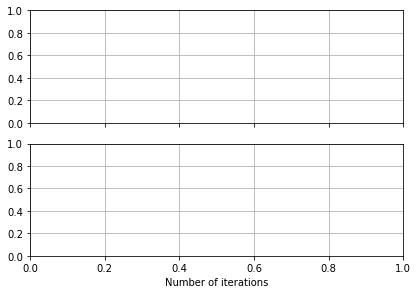

In [26]:
plotter, fig, ax = create_plot(["loss", "accuracy"])


In [27]:
training_data

array([['grown man who owns bane action figure has love to give', 1],
       ['dolphin spends amazing vacation swimming with stockbroker', 1],
       ['finding comfort in numbers', 0],
       ...,
       ["arianna huffington urges gop voters to 'trexit' and dump trump",
        0],
       ["don't expect to see kim kardashian give birth on tv again", 0],
       ["'troubled' republicans have no plans to do anything about james comey's firing",
        0]], dtype=object)

In [28]:
vec = torchtext.vocab.GloVe(name = '6B', dim = 100)

In [29]:
trainingEmbeddings = [vec.get_vecs_by_tokens(sentence).tolist() for sentence in tokenizedTrainingData]
testingEmbeddings = [vec.get_vecs_by_tokens(sentence).tolist() for sentence in tokenizedTestingData]


In [30]:
trainingEmbeddings[0:5]

[[[-0.22526000440120697,
   0.935949981212616,
   0.11685000360012054,
   -0.11065000295639038,
   0.0702420026063919,
   -0.11528000235557556,
   0.3901599943637848,
   -0.10732000321149826,
   0.5676299929618835,
   0.05465799942612648,
   -0.6553099751472473,
   -0.22844000160694122,
   0.7906200289726257,
   0.014519000425934792,
   0.013868999667465687,
   -0.549839973449707,
   -0.13478000462055206,
   0.3918899893760681,
   -0.07859300076961517,
   0.3909800052642822,
   -0.11957000195980072,
   0.5923600196838379,
   0.6704099774360657,
   0.20896999537944794,
   -0.1973699927330017,
   0.28738000988960266,
   0.382860004901886,
   -0.9277499914169312,
   -0.20286999642848969,
   0.37599998712539673,
   0.22618000209331512,
   0.481550008058548,
   0.8641800284385681,
   -0.6815800070762634,
   0.5220500230789185,
   0.8305699825286865,
   0.10296999663114548,
   -0.2247599959373474,
   -0.19125999510288239,
   -0.13391999900341034,
   -0.12691999971866608,
   -0.89697998762130

In [31]:
training_max_length = max(len(sentence) for sentence in trainingEmbeddings)
testing_max_length = max(len(sentence) for sentence in testingEmbeddings)

max_length = max(training_max_length, testing_max_length)

training_padded = np.zeros((len(trainingEmbeddings), max_length, 100))

for sentence_idx in range(len(trainingEmbeddings)):
    sentence = trainingEmbeddings[sentence_idx]
    for word_idx in range(len(trainingEmbeddings[sentence_idx])):
        word = sentence[word_idx]
        training_padded[sentence_idx][word_idx] = word


In [32]:
testing_padded = np.zeros((len(testingEmbeddings), max_length, 100))

for sentence_idx in range(len(testingEmbeddings)):
    sentence = testingEmbeddings[sentence_idx]
    for word_idx in range(len(testingEmbeddings[sentence_idx])):
        word = sentence[word_idx]
        testing_padded[sentence_idx][word_idx] = word

In [33]:
num_epochs = 10
batch_size = 100

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
# print(training_data.shape)
for epoch in range(num_epochs):
    print(epoch)
    idxs = np.arange(len(training_data))  # -> array([0, 1, ..., num_train-1])
    np.random.shuffle(idxs)  # shuffles indices in-place
    
    for batch_cnt in range(len(training_data) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]
#         print(training_data.shape)
#         print(training_data[batch_indices])
        batch = training_padded[batch_indices]  # <COGSTUB> get the random batch of our training data
        truth = training_data[batch_indices][:, 1] # <COGSTUB> get the true labels for this batch of images
        truth = np.vstack(truth).astype(np.int)

#         print(batch)
#         truth = np.reshape(truth, (100, 1))
#         print(truth.shape)
        text_lengths = [len(sentence) for sentence in batch]
        training_paddedArr = torch.from_numpy(training_padded)
        b = torch.tensor(batch, dtype = torch.float32, device=device)
#         t = torch.tensor(text_lengths, dtype = torch.long, device=torch.device('cpu'))
#         print("btype:",b.type())
#         print("ttype:",t.type())
        t = text_lengths
        prediction = model(b,t)
#         prediction = torch.reshape(prediction, (100,))
        
        
#         print(prediction.shape)
#         print(prediction)
#         print(truth.shape)
#         print(type(truth[0]))
    
        
#         loss = sigmoidBCE(prediction, torch.from_numpy(truth).to(device))
#         torch.abs(prediction)
#         print("prediction:", prediction)
#         print("truth:", truth)
        
        loss = criterion(prediction, torch.tensor(truth, dtype=torch.float, device=device))
        print("Training Loss: ", loss.item())

        loss.backward()
        optimizer.step()
        acc = binary_accuracy(prediction, torch.tensor(truth, dtype = torch.float32, device=device))
        print("Training accuracy: ", acc.item())

        plotter.set_train_batch(
            {"loss": loss.item(), "accuracy": acc.item()}, batch_size=batch_size
        )
    
      # Here, we evaluate our model on batches of *testing* data
    # this will show us how good our model does on data that
    # it has never encountered
    # Iterate over batches of *testing* data
    for batch_cnt in range(0, len(testing_data) // batch_size):
        idxs = np.arange(len(testing_data))
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]  # <COGSTUB>  get the batch of our **test** data
        batch = testing_padded[batch_indices]  # <COGSTUB>  get the batch of our **test** labels

        with torch.no_grad():
            # get your model's prediction on the test-batch
            text_lengths = [len(sentence) for sentence in batch]
            
            b = torch.tensor(batch, dtype = torch.float32, device=device)
#             t = torch.tensor(text_lengths, dtype = torch.torch.long, device=torch.device('cpu'))
            t = text_lengths
            prediction = model(b,t)
            # get the truth values for that test-batch
            truth = training_data[batch_indices][:, 1] # <COGSTUB> get the true labels for this batch of images
            truth = np.vstack(truth).astype(np.int)

            # compute the test accuracy
            acc = binary_accuracy(prediction, torch.tensor(truth, dtype = torch.float32, device=device))
            print("Validation accuracy: ", acc.item())

        # log the test-accuracy in noggin
        plotter.set_test_batch({"accuracy": acc.item()}, batch_size=batch_size)

    plotter.set_train_epoch()
    plotter.set_test_epoch()
plotter.plot()    

0
Training Loss:  0.6903356909751892


C:\Users\evan_\AppData\Local\Temp\ipykernel_32908\177358126.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  truth = np.vstack(truth).astype(np.int)


Training accuracy:  0.5600000023841858
Training Loss:  0.6892946362495422
Training accuracy:  0.5299999713897705
Training Loss:  0.6709328889846802
Training accuracy:  0.5999999642372131
Training Loss:  0.7044457197189331
Training accuracy:  0.5
Training Loss:  0.6935379505157471
Training accuracy:  0.5199999809265137
Training Loss:  0.6461501717567444
Training accuracy:  0.6299999952316284
Training Loss:  0.6739498972892761
Training accuracy:  0.5299999713897705
Training Loss:  0.6624923348426819
Training accuracy:  0.6399999856948853
Training Loss:  0.6532531380653381
Training accuracy:  0.6699999570846558
Training Loss:  0.638308048248291
Training accuracy:  0.7299999594688416
Training Loss:  0.625991940498352
Training accuracy:  0.7099999785423279
Training Loss:  0.7204510569572449
Training accuracy:  0.6200000047683716
Training Loss:  0.6890488862991333
Training accuracy:  0.6499999761581421
Training Loss:  0.6787926554679871
Training accuracy:  0.5899999737739563
Training Loss:  

Training accuracy:  0.5299999713897705
Training Loss:  1.02153742313385
Training accuracy:  0.5199999809265137
Training Loss:  0.7950773239135742
Training accuracy:  0.550000011920929
Training Loss:  0.8281784653663635
Training accuracy:  0.5600000023841858
Training Loss:  0.7914184331893921
Training accuracy:  0.6100000143051147
Training Loss:  0.8263984322547913
Training accuracy:  0.5899999737739563
Training Loss:  0.7535000443458557
Training accuracy:  0.6599999666213989
Training Loss:  0.7859299778938293
Training accuracy:  0.5999999642372131
Training Loss:  0.5725305676460266
Training accuracy:  0.699999988079071
Training Loss:  0.624011218547821
Training accuracy:  0.6399999856948853
Training Loss:  0.5575553774833679
Training accuracy:  0.75
Training Loss:  0.5545051693916321
Training accuracy:  0.7199999690055847
Training Loss:  0.5953291058540344
Training accuracy:  0.7099999785423279
Training Loss:  0.6395375728607178
Training accuracy:  0.6100000143051147
Training Loss:  0.

C:\Users\evan_\AppData\Local\Temp\ipykernel_32908\177358126.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  truth = np.vstack(truth).astype(np.int)


Validation accuracy:  0.5399999618530273
Validation accuracy:  0.4099999964237213
Validation accuracy:  0.5399999618530273
Validation accuracy:  0.6200000047683716
Validation accuracy:  0.4899999797344208
Validation accuracy:  0.5299999713897705
Validation accuracy:  0.550000011920929
Validation accuracy:  0.6399999856948853
Validation accuracy:  0.5299999713897705
Validation accuracy:  0.550000011920929
Validation accuracy:  0.5699999928474426
Validation accuracy:  0.4699999988079071
Validation accuracy:  0.41999998688697815
Validation accuracy:  0.47999998927116394
Validation accuracy:  0.5299999713897705
Validation accuracy:  0.5600000023841858
Validation accuracy:  0.5799999833106995
Validation accuracy:  0.429999977350235
Validation accuracy:  0.5299999713897705
Validation accuracy:  0.47999998927116394
Validation accuracy:  0.550000011920929
Validation accuracy:  0.4599999785423279
Validation accuracy:  0.5
Validation accuracy:  0.5
Validation accuracy:  0.47999998927116394
Valid

Training accuracy:  0.7199999690055847
Training Loss:  0.6753347516059875
Training accuracy:  0.7400000095367432
Training Loss:  0.5528097152709961
Training accuracy:  0.75
Training Loss:  0.5625215172767639
Training accuracy:  0.7599999904632568
Training Loss:  0.6924601793289185
Training accuracy:  0.6800000071525574
Training Loss:  0.6400405168533325
Training accuracy:  0.7599999904632568
Training Loss:  0.7156729102134705
Training accuracy:  0.7599999904632568
Training Loss:  0.6196503043174744
Training accuracy:  0.7099999785423279
Training Loss:  0.8452918529510498
Training accuracy:  0.6299999952316284
Training Loss:  0.5478872656822205
Training accuracy:  0.7799999713897705
Training Loss:  0.5872490406036377
Training accuracy:  0.7799999713897705
Training Loss:  0.6035589575767517
Training accuracy:  0.7699999809265137
Training Loss:  0.7507556676864624
Training accuracy:  0.6599999666213989
Training Loss:  0.5518414378166199
Training accuracy:  0.75
Training Loss:  0.747597634

Training Loss:  0.6210788488388062
Training accuracy:  0.6800000071525574
Training Loss:  0.6221702694892883
Training accuracy:  0.7199999690055847
Training Loss:  0.6203199625015259
Training accuracy:  0.7400000095367432
Training Loss:  0.6166905760765076
Training accuracy:  0.6800000071525574
Training Loss:  0.7565970420837402
Training accuracy:  0.6100000143051147
Training Loss:  0.49069494009017944
Training accuracy:  0.7299999594688416
Training Loss:  0.5966627597808838
Training accuracy:  0.7099999785423279
Training Loss:  0.6396114826202393
Training accuracy:  0.7400000095367432
Training Loss:  0.6982089281082153
Training accuracy:  0.7400000095367432
Validation accuracy:  0.4399999976158142
Validation accuracy:  0.4899999797344208
Validation accuracy:  0.47999998927116394
Validation accuracy:  0.47999998927116394
Validation accuracy:  0.5099999904632568
Validation accuracy:  0.429999977350235
Validation accuracy:  0.4899999797344208
Validation accuracy:  0.5299999713897705
Vali

Training accuracy:  0.699999988079071
Training Loss:  0.5748689770698547
Training accuracy:  0.6299999952316284
Training Loss:  0.5874254703521729
Training accuracy:  0.699999988079071
Training Loss:  0.526780366897583
Training accuracy:  0.6899999976158142
Training Loss:  0.5268891453742981
Training accuracy:  0.7099999785423279
Training Loss:  0.5972078442573547
Training accuracy:  0.6499999761581421
Training Loss:  0.62473464012146
Training accuracy:  0.5699999928474426
Training Loss:  0.6353472471237183
Training accuracy:  0.6200000047683716
Training Loss:  0.7382058501243591
Training accuracy:  0.5600000023841858
Training Loss:  0.6963602304458618
Training accuracy:  0.5899999737739563
Training Loss:  0.7328996062278748
Training accuracy:  0.5299999713897705
Training Loss:  0.8123430609703064
Training accuracy:  0.41999998688697815
Training Loss:  0.8152340650558472
Training accuracy:  0.5699999928474426
Training Loss:  0.7370520830154419
Training accuracy:  0.5899999737739563
Tra

Training accuracy:  0.6800000071525574
Training Loss:  0.7726872563362122
Training accuracy:  0.7299999594688416
Training Loss:  0.7480802536010742
Training accuracy:  0.7199999690055847
Training Loss:  0.7170640230178833
Training accuracy:  0.7699999809265137
Training Loss:  0.5987004637718201
Training accuracy:  0.8100000023841858
Training Loss:  1.0555285215377808
Training accuracy:  0.699999988079071
Training Loss:  0.6596017479896545
Training accuracy:  0.75
Training Loss:  0.6910015940666199
Training accuracy:  0.7099999785423279
Training Loss:  0.7571513056755066
Training accuracy:  0.7899999618530273
Training Loss:  0.8219922184944153
Training accuracy:  0.7599999904632568
Training Loss:  0.6248054504394531
Training accuracy:  0.7699999809265137
Training Loss:  0.9219222664833069
Training accuracy:  0.6699999570846558
Training Loss:  0.7424412369728088
Training accuracy:  0.7999999523162842
Training Loss:  0.748927116394043
Training accuracy:  0.699999988079071
Training Loss:  

Training accuracy:  0.7299999594688416
Training Loss:  1.3169119358062744
Training accuracy:  0.6699999570846558
Training Loss:  1.4652841091156006
Training accuracy:  0.6200000047683716
Training Loss:  0.8700976371765137
Training accuracy:  0.7199999690055847
Training Loss:  1.2769067287445068
Training accuracy:  0.6399999856948853
Training Loss:  1.4497371912002563
Training accuracy:  0.6399999856948853
Training Loss:  1.370045781135559
Training accuracy:  0.5899999737739563
Training Loss:  1.1913286447525024
Training accuracy:  0.699999988079071
Training Loss:  0.9818326830863953
Training accuracy:  0.6800000071525574
Training Loss:  0.8297888040542603
Training accuracy:  0.7699999809265137
Training Loss:  0.815230667591095
Training accuracy:  0.7099999785423279
Training Loss:  1.274791955947876
Training accuracy:  0.6499999761581421
Training Loss:  1.0176903009414673
Training accuracy:  0.7299999594688416
Training Loss:  1.1701229810714722
Training accuracy:  0.6800000071525574
Tra

Training accuracy:  0.4899999797344208
Training Loss:  0.9245848059654236
Training accuracy:  0.6200000047683716
Training Loss:  1.1495521068572998
Training accuracy:  0.5699999928474426
Training Loss:  0.9923210144042969
Training accuracy:  0.5999999642372131
Training Loss:  1.022523045539856
Training accuracy:  0.5899999737739563
Training Loss:  1.1889406442642212
Training accuracy:  0.5399999618530273
Training Loss:  1.0722448825836182
Training accuracy:  0.5899999737739563
Training Loss:  1.1747288703918457
Training accuracy:  0.5899999737739563
Training Loss:  1.2507400512695312
Training accuracy:  0.5299999713897705
Training Loss:  1.2081445455551147
Training accuracy:  0.5299999713897705
Training Loss:  1.0366592407226562
Training accuracy:  0.5799999833106995
Training Loss:  1.066092848777771
Training accuracy:  0.5600000023841858
Training Loss:  1.0333361625671387
Training accuracy:  0.6299999952316284
Training Loss:  1.3840901851654053
Training accuracy:  0.47999998927116394


Training accuracy:  0.6200000047683716
Training Loss:  0.8801417350769043
Training accuracy:  0.699999988079071
Training Loss:  0.9821993112564087
Training accuracy:  0.6200000047683716
Training Loss:  0.8589575886726379
Training accuracy:  0.6100000143051147
Training Loss:  0.8109133839607239
Training accuracy:  0.6499999761581421
Training Loss:  0.9817672371864319
Training accuracy:  0.5699999928474426
Training Loss:  0.8809664845466614
Training accuracy:  0.5699999928474426
Training Loss:  0.9572365283966064
Training accuracy:  0.5699999928474426
Training Loss:  0.8533006310462952
Training accuracy:  0.5600000023841858
Training Loss:  0.9620917439460754
Training accuracy:  0.5299999713897705
Training Loss:  0.934161365032196
Training accuracy:  0.5899999737739563
Training Loss:  0.8517942428588867
Training accuracy:  0.6299999952316284
Training Loss:  0.8083623051643372
Training accuracy:  0.6200000047683716
Training Loss:  0.8970266580581665
Training accuracy:  0.5399999618530273
T

Training Loss:  1.0020982027053833
Training accuracy:  0.5399999618530273
Training Loss:  1.0394201278686523
Training accuracy:  0.5600000023841858
Training Loss:  1.1481237411499023
Training accuracy:  0.5600000023841858
Training Loss:  0.7906053066253662
Training accuracy:  0.6100000143051147
Training Loss:  0.9789575934410095
Training accuracy:  0.7199999690055847
Training Loss:  0.9478045701980591
Training accuracy:  0.6100000143051147
Training Loss:  1.004456639289856
Training accuracy:  0.5999999642372131
Training Loss:  1.1274588108062744
Training accuracy:  0.550000011920929
Training Loss:  0.9429789781570435
Training accuracy:  0.5799999833106995
Training Loss:  1.0646828413009644
Training accuracy:  0.6399999856948853
Training Loss:  0.8787243962287903
Training accuracy:  0.6899999976158142
Training Loss:  1.015734076499939
Training accuracy:  0.5999999642372131
Training Loss:  1.1040526628494263
Training accuracy:  0.6299999952316284
Training Loss:  1.319529414176941
Trainin

Training accuracy:  0.7999999523162842
Training Loss:  1.25104820728302
Training accuracy:  0.5899999737739563
Training Loss:  0.6822149753570557
Training accuracy:  0.7299999594688416
Training Loss:  0.7437798976898193
Training accuracy:  0.6899999976158142
Training Loss:  1.0893685817718506
Training accuracy:  0.6699999570846558
Training Loss:  0.7256157994270325
Training accuracy:  0.7299999594688416
Training Loss:  0.8898131251335144
Training accuracy:  0.6899999976158142
Training Loss:  0.7069512009620667
Training accuracy:  0.7099999785423279
Training Loss:  0.7588269710540771
Training accuracy:  0.6899999976158142
Training Loss:  0.636032223701477
Training accuracy:  0.7699999809265137
Training Loss:  1.0502773523330688
Training accuracy:  0.699999988079071
Training Loss:  0.9033490419387817
Training accuracy:  0.699999988079071
Training Loss:  0.8838781714439392
Training accuracy:  0.7099999785423279
Training Loss:  0.9107187986373901
Training accuracy:  0.7299999594688416
Trai

Training Loss:  0.6624042391777039
Training accuracy:  0.6899999976158142
Training Loss:  0.9715427160263062
Training accuracy:  0.5999999642372131
Training Loss:  0.7122206091880798
Training accuracy:  0.6800000071525574
Training Loss:  0.4815447926521301
Training accuracy:  0.7899999618530273
Training Loss:  0.5390343070030212
Training accuracy:  0.7999999523162842
Training Loss:  0.7155722379684448
Training accuracy:  0.699999988079071
Training Loss:  0.6975919008255005
Training accuracy:  0.7299999594688416
Training Loss:  0.6523963212966919
Training accuracy:  0.7199999690055847
Training Loss:  0.733039379119873
Training accuracy:  0.6499999761581421
Training Loss:  0.6019107699394226
Training accuracy:  0.7599999904632568
Training Loss:  0.641649603843689
Training accuracy:  0.699999988079071
Training Loss:  0.8008545637130737
Training accuracy:  0.6899999976158142
Training Loss:  0.6872486472129822
Training accuracy:  0.7099999785423279
Training Loss:  0.7166814804077148
Trainin

Training accuracy:  0.5899999737739563
Training Loss:  0.6772637963294983
Training accuracy:  0.699999988079071
Training Loss:  0.7803996205329895
Training accuracy:  0.6599999666213989
Training Loss:  0.7058125138282776
Training accuracy:  0.6699999570846558
Training Loss:  0.7798566222190857
Training accuracy:  0.6200000047683716
Training Loss:  0.724961519241333
Training accuracy:  0.6299999952316284
Training Loss:  0.7281737923622131
Training accuracy:  0.6200000047683716
Training Loss:  0.6276506185531616
Training accuracy:  0.6800000071525574
Training Loss:  0.5730626583099365
Training accuracy:  0.6899999976158142
Training Loss:  0.61342453956604
Training accuracy:  0.6800000071525574
Training Loss:  0.5992007851600647
Training accuracy:  0.699999988079071
Training Loss:  0.6882787346839905
Training accuracy:  0.6899999976158142
Training Loss:  0.6895229816436768
Training accuracy:  0.6299999952316284
Training Loss:  0.765906572341919
Training accuracy:  0.5999999642372131
Train

Training accuracy:  0.6599999666213989
Training Loss:  0.7140244841575623
Training accuracy:  0.6200000047683716
Training Loss:  0.6186662316322327
Training accuracy:  0.6499999761581421
Training Loss:  0.6015638113021851
Training accuracy:  0.699999988079071
Training Loss:  0.6724545359611511
Training accuracy:  0.5799999833106995
Training Loss:  0.708392858505249
Training accuracy:  0.5199999809265137
Training Loss:  0.6336105465888977
Training accuracy:  0.6499999761581421
Training Loss:  0.6241538524627686
Training accuracy:  0.6299999952316284
Training Loss:  0.5934146046638489
Training accuracy:  0.6699999570846558
Training Loss:  0.6574705243110657
Training accuracy:  0.6100000143051147
Training Loss:  0.6060105562210083
Training accuracy:  0.7099999785423279
Training Loss:  0.5785338878631592
Training accuracy:  0.7199999690055847
Training Loss:  0.6049070954322815
Training accuracy:  0.6599999666213989
Training Loss:  0.5717245936393738
Training accuracy:  0.7199999690055847
T

Training Loss:  1.1438920497894287
Training accuracy:  0.5399999618530273
Training Loss:  0.9911614656448364
Training accuracy:  0.5899999737739563
Training Loss:  1.196522831916809
Training accuracy:  0.5199999809265137
Training Loss:  0.9660031199455261
Training accuracy:  0.5899999737739563
Training Loss:  1.1358040571212769
Training accuracy:  0.5099999904632568
Training Loss:  0.9159086346626282
Training accuracy:  0.6200000047683716
Training Loss:  1.1176601648330688
Training accuracy:  0.5399999618530273
Training Loss:  0.9442322254180908
Training accuracy:  0.5699999928474426
Training Loss:  0.8886961340904236
Training accuracy:  0.6299999952316284
Training Loss:  1.0727168321609497
Training accuracy:  0.5199999809265137
Training Loss:  1.009860634803772
Training accuracy:  0.5299999713897705
Training Loss:  0.9279605746269226
Training accuracy:  0.5999999642372131
Training Loss:  1.0070418119430542
Training accuracy:  0.550000011920929
Training Loss:  0.6811485886573792
Traini

Training accuracy:  0.3799999952316284
Training Loss:  1.3288671970367432
Training accuracy:  0.47999998927116394
Training Loss:  1.379251480102539
Training accuracy:  0.4399999976158142
Training Loss:  1.2232099771499634
Training accuracy:  0.47999998927116394
Training Loss:  1.184485912322998
Training accuracy:  0.5399999618530273
Training Loss:  1.1328425407409668
Training accuracy:  0.5399999618530273
Training Loss:  1.1354598999023438
Training accuracy:  0.5299999713897705
Training Loss:  1.3125594854354858
Training accuracy:  0.44999998807907104
Training Loss:  1.2831180095672607
Training accuracy:  0.429999977350235
Training Loss:  1.2918262481689453
Training accuracy:  0.4399999976158142
Training Loss:  1.2141519784927368
Training accuracy:  0.4599999785423279
Training Loss:  1.3273875713348389
Training accuracy:  0.4599999785423279
Training Loss:  1.1699087619781494
Training accuracy:  0.5
Training Loss:  1.298518180847168
Training accuracy:  0.4599999785423279
Training Loss: 

Training accuracy:  0.4699999988079071
Training Loss:  1.137550950050354
Training accuracy:  0.550000011920929
Training Loss:  1.3988198041915894
Training accuracy:  0.5099999904632568
Training Loss:  1.110172986984253
Training accuracy:  0.550000011920929
Training Loss:  0.890561044216156
Training accuracy:  0.6399999856948853
Training Loss:  1.1076946258544922
Training accuracy:  0.6399999856948853
Training Loss:  1.1841884851455688
Training accuracy:  0.5600000023841858
Training Loss:  1.3480809926986694
Training accuracy:  0.5299999713897705
Training Loss:  1.2604881525039673
Training accuracy:  0.5799999833106995
Training Loss:  1.2747695446014404
Training accuracy:  0.5399999618530273
Training Loss:  1.2940936088562012
Training accuracy:  0.5199999809265137
Training Loss:  1.2414222955703735
Training accuracy:  0.5899999737739563
Training Loss:  1.1837776899337769
Training accuracy:  0.6299999952316284
Training Loss:  1.1511296033859253
Training accuracy:  0.6499999761581421
Trai

Training Loss:  0.7203163504600525
Training accuracy:  0.7099999785423279
Training Loss:  0.7570704221725464
Training accuracy:  0.6299999952316284
Training Loss:  0.7373077273368835
Training accuracy:  0.7099999785423279
Training Loss:  0.6923690438270569
Training accuracy:  0.6499999761581421
Training Loss:  0.5700765252113342
Training accuracy:  0.7099999785423279
Training Loss:  0.5718022584915161
Training accuracy:  0.7299999594688416
Training Loss:  0.544861912727356
Training accuracy:  0.7699999809265137
Training Loss:  0.5689854025840759
Training accuracy:  0.7400000095367432
Training Loss:  0.6426107883453369
Training accuracy:  0.7199999690055847
Training Loss:  0.5563802123069763
Training accuracy:  0.7099999785423279
Training Loss:  0.7236745953559875
Training accuracy:  0.6800000071525574
Training Loss:  0.6418951153755188
Training accuracy:  0.6800000071525574
Training Loss:  0.6051943302154541
Training accuracy:  0.699999988079071
Training Loss:  0.4646272659301758
Train

Training accuracy:  0.41999998688697815
Training Loss:  1.8672690391540527
Training accuracy:  0.4599999785423279
Training Loss:  1.8549718856811523
Training accuracy:  0.4399999976158142
Training Loss:  1.7446774244308472
Training accuracy:  0.41999998688697815
Training Loss:  1.956682562828064
Training accuracy:  0.4599999785423279
Training Loss:  2.2522635459899902
Training accuracy:  0.3799999952316284
Training Loss:  1.7896676063537598
Training accuracy:  0.47999998927116394
Training Loss:  1.7467968463897705
Training accuracy:  0.5099999904632568
Training Loss:  2.1108803749084473
Training accuracy:  0.429999977350235
Training Loss:  1.7975596189498901
Training accuracy:  0.5
Training Loss:  1.9484285116195679
Training accuracy:  0.429999977350235
Training Loss:  1.7748968601226807
Training accuracy:  0.47999998927116394
Training Loss:  1.9969974756240845
Training accuracy:  0.4399999976158142
Training Loss:  2.3083560466766357
Training accuracy:  0.32999998331069946
Training Los

Training Loss:  0.880961000919342
Training accuracy:  0.6599999666213989
Training Loss:  1.1020314693450928
Training accuracy:  0.6299999952316284
Training Loss:  0.9503861665725708
Training accuracy:  0.699999988079071
Training Loss:  1.0547751188278198
Training accuracy:  0.6800000071525574
Training Loss:  1.019136667251587
Training accuracy:  0.6800000071525574
Training Loss:  1.0938739776611328
Training accuracy:  0.6699999570846558
Training Loss:  1.0788360834121704
Training accuracy:  0.6399999856948853
Training Loss:  0.6759204864501953
Training accuracy:  0.7599999904632568
Training Loss:  0.9663527607917786
Training accuracy:  0.6399999856948853
Training Loss:  0.9735662341117859
Training accuracy:  0.7099999785423279
Training Loss:  1.3056591749191284
Training accuracy:  0.5099999904632568
Training Loss:  1.2770822048187256
Training accuracy:  0.5099999904632568
Training Loss:  1.2582547664642334
Training accuracy:  0.5799999833106995
Training Loss:  1.6458312273025513
Traini